In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL

## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 100
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
original_dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
original_stats = pd.DataFrame.from_dict(original_dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_04-discrimination_dataset"
# data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_11-discrimination_dataset"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
new_stats = pd.DataFrame.from_dict(dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
dset.worms_properties_stats = original_dset.worms_properties_stats
dset.worms_properties = (
    dset.worms_properties[:] * new_stats.loc["std"].to_numpy()
    + new_stats.loc["mean"].to_numpy()
    - original_stats.loc["mean"].to_numpy()
) / original_stats.loc["std"].to_numpy()
dloader = DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=12)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "full", "model": [model]}),
        ]
    ).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/feedback-with-values*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_vals", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

for folder in list(np.sort(glob.glob("../figures/stats-panel/feedback-with-estimates*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_esti", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

In [7]:
models = models[models["lambda_RC"] > 0].reset_index(drop=True)
models = models[models["model_type"]=="full"].reset_index(drop=True)

In [8]:
models

,rand_seed,lambda_RC,model_type,model
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


## Inspect discrimination data

In [9]:
eis = next(iter(dloader))[0]
props = next(iter(dloader))[1].to(torch.float32)
discrimination_data = raw_dataset["worms"]["dataframe"].copy()
discrimination_data["preferred"] = (discrimination_data["resistances"] == 0) & (
    discrimination_data["capacitances"] == 1
)
max_mod = eis[:, :, 5, 6]
print(eis.shape, max_mod.shape)

torch.Size([60, 2, 20, 30]) torch.Size([60, 2])


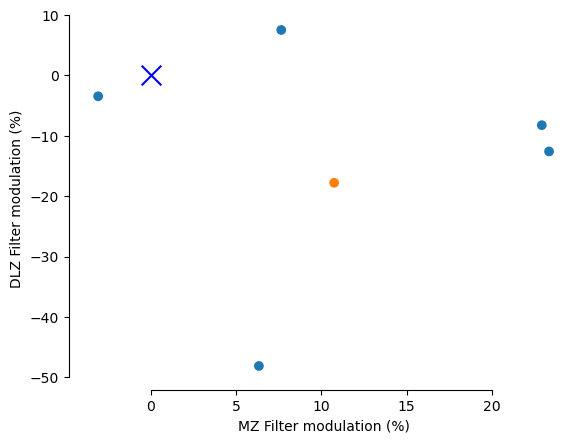

In [10]:
mask = raw_dataset["worms"]["dataframe"]["position_ys"] == 0
mask &= raw_dataset["worms"]["dataframe"]["radii"] == 1
plt.scatter(*eis[mask, :, 5, 6].T, c=[f"C{int(x)}" for x in discrimination_data[mask]["preferred"]])
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.savefig("discrimination-feat-space.svg")
plt.show()

### Create discrimination training and testing data

In [35]:
n_repeats = 100
train_mask = raw_dataset["worms"]["dataframe"]["position_ys"].apply(lambda x: x not in [1,3])
train_eis = torch.tile(eis[train_mask], (n_repeats, 1, 1, 1))
train_eis = train_eis + torch.randn_like(train_eis) * 0.02
train_props = torch.tile(props[train_mask], (n_repeats, 1))
train_labels = np.tile(discrimination_data["preferred"][train_mask].to_numpy().astype(int), (n_repeats,))

valid_mask = raw_dataset["worms"]["dataframe"]["position_ys"].apply(lambda x: x in [1,3])
valid_eis = torch.tile(eis[valid_mask], (n_repeats, 1, 1, 1))
valid_eis = valid_eis + torch.randn_like(valid_eis) * 0.02
valid_props = torch.tile(props[valid_mask], (n_repeats, 1))
valid_props_df = pd.concat([discrimination_data[["resistances", "capacitances", "radii", "position_ys", "preferred"]][valid_mask]] * n_repeats)
valid_props_df["preferred"] = valid_props_df["preferred"].astype(int)
valid_labels = valid_props_df["preferred"].to_numpy()

## Compute models predictions

In [36]:
models["prediction_train"] = models.apply(
    lambda x: (
        x["model"].model(train_eis, train_props[:, 1], train_props[:, 3]).detach().cpu().numpy()
        if x["model_type"] == "feedback_vals"
        else x["model"].model(train_eis).detach().cpu().numpy()
    ),
    axis=1,
)
models["prediction_valid"] = models.apply(
    lambda x: (
        x["model"].model(valid_eis, valid_props[:, 1], valid_props[:, 3]).detach().cpu().numpy()
        if x["model_type"] == "feedback_vals"
        else x["model"].model(valid_eis).detach().cpu().numpy()
    ),
    axis=1,
)

In [37]:
def train_discrimination(dfrow):
    shuffle_perm = np.random.permutation(len(dfrow["prediction_train"]))
    train_x = dfrow["prediction_train"][shuffle_perm]
    train_y = train_labels[shuffle_perm]
    rfc = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1)
    rfc.fit(train_x, train_y)
    train_preds = rfc.predict(train_x)
    valid_x = dfrow["prediction_valid"]
    valid_y = valid_labels
    valid_preds = rfc.predict(valid_x)

    dfrow["train_accuracy"] = (train_preds == train_y).mean()
    dfrow["train_preds"] = train_preds
    dfrow["train_probs"] = rfc.predict_proba(train_x)[:, 1]

    dfrow["valid_accuracy"] = (valid_preds == valid_y).mean()
    dfrow["valid_preds"] = valid_preds
    dfrow["valid_probs"] = rfc.predict_proba(valid_x)[:, 1]
    return dfrow

In [38]:
models = models.apply(train_discrimination, axis=1)

In [39]:
np.unique(models["train_preds"][3], return_counts=True), np.unique(models["valid_preds"][3], return_counts=True)

((array([0, 1]), array([2997,  603])), (array([0, 1]), array([2100,  300])))

In [40]:
models.head()

,rand_seed,lambda_RC,model_type,model,prediction_train,prediction_valid,train_accuracy,train_preds,train_probs,valid_accuracy,valid_preds,valid_probs
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.1536106, -1.7688352, 0.033717923, -1.09075...","[[1.0674406, -1.7260936, 0.17358112, -1.389114...",0.992222,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.9841819401364621, 0.9976002689966259, 0.008...",0.895417,"[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.00036231884057971004, 0.0, 0.0, 0.9855..."
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.1993239, -1.8290832, 0.12889864, -1.274963...","[[1.3513329, -1.7249056, 0.108680084, -1.26751...",0.976944,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.00029585798816568064, 0.7580826967674102, 0...",0.940000,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.3321040577344329, 0.656..."
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.064611, -1.8777552, -0.07610889, -1.396406...","[[1.0376232, -1.8515077, 0.07407012, -1.533450...",0.998889,"[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, ...","[0.0, 0.9354360150672928, 0.022807121785472412...",0.935417,"[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.8884488300621135, 0.881..."
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.1209422, -1.8212104, 0.08506817, -1.241145...","[[1.1424949, -1.7916949, 0.06737087, -1.399338...",0.999167,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9972218930295...",0.947500,"[0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.9675658411956758, 0.888..."
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.2241585, -1.8694367, 0.0013101362, -1.1985...","[[1.185772, -1.9096556, 0.01757155, -1.3472668...",0.995556,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.05297717995594639, 0.0,...",0.876250,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.13062386715914442, 0.42..."


In [41]:
valid_stats = pd.DataFrame()
for _, row in models.iterrows():
    model_id = row.name
    valid_props_df["predictions"] = row["valid_preds"]
    temp_valid_stats = valid_props_df.groupby(["resistances", "capacitances", "radii", "position_ys"]).apply(
        lambda x: (x["predictions"] == 1).sum() / x.shape[0]
    )
    temp_valid_stats.name="percent_intakes"
    temp_valid_stats = temp_valid_stats.reset_index()
    temp_valid_stats["model_id"] = model_id
    temp_valid_stats["model_type"] = row["model_type"]
    valid_stats = pd.concat([valid_stats, temp_valid_stats], axis=0)
valid_stats = valid_stats.reset_index(drop=True)
valid_stats = valid_stats.groupby(["model_type", "resistances", "capacitances", "radii", "position_ys"]).apply(lambda x: pd.Series([x["percent_intakes"].mean(), x["percent_intakes"].std()]))
valid_stats.columns = ["mean", "std"]
valid_stats = valid_stats.reset_index()

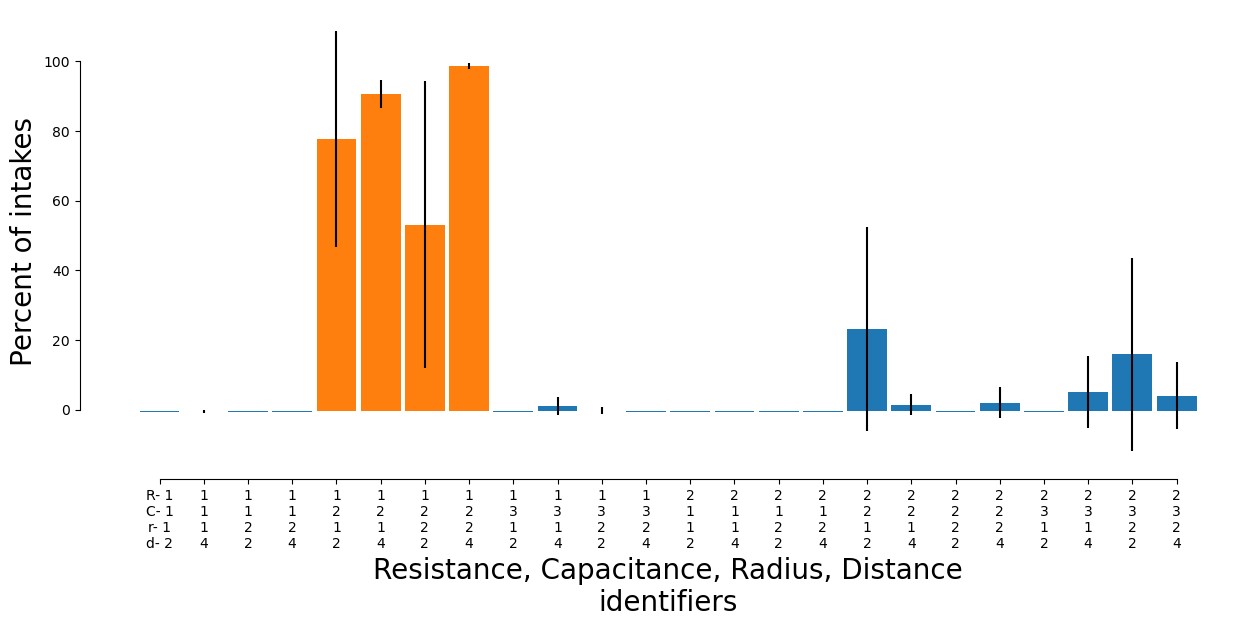

In [42]:
fig = plt.figure(figsize=(15, 6))
offset = -0.3
ticks = []
for i, row in valid_stats.iterrows():
    c = "C1" if row["resistances"] == 0 and row["capacitances"] == 1 else "C0"
    plt.bar(
        x=i,
        height=row["mean"] * 100 + offset,
        yerr=row["std"] * 100,
        bottom=offset,
        color=c,
        width=0.9,
    )
    if i == 0:
        ticks.append(
            [
                i,
                f"R- {row["resistances"]+1:.0f}\nC- {row["capacitances"]+1:.0f}\nr- {row["radii"]+1:.0f}\nd- {row["position_ys"]+1:.0f}",
            ]
        )
    else:
        ticks.append(
            [
                i,
                f"{row["resistances"]+1:.0f}\n{row["capacitances"]+1:.0f}\n{row["radii"]+1:.0f}\n{row["position_ys"]+1:.0f}",
            ]
        )
plt.xticks(*zip(*ticks))
plt.ylabel("Percent of intakes", fontsize=20)
plt.xlabel("Resistance, Capacitance, Radius, Distance\nidentifiers", fontsize=20)
sns.despine(offset=5, trim=True)
plt.savefig("discrimination-performance.svg")
plt.show()

## Histograms of model predictions

model_type    full
lambda_RC        1
Name: 0, dtype: object


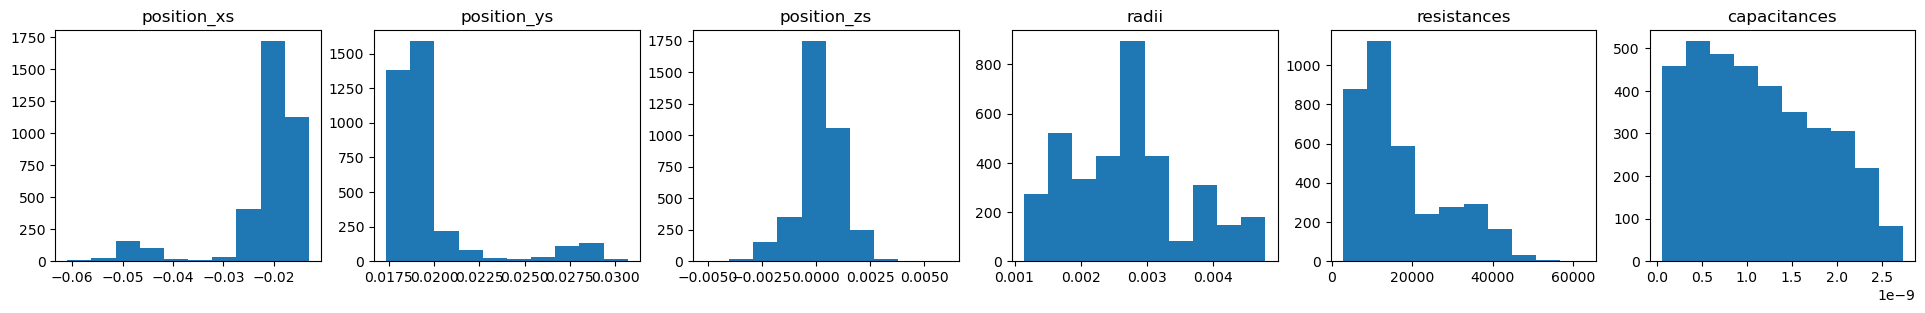

In [43]:
model_id = 0
print(models.iloc[model_id][["model_type", "lambda_RC"]])
fig, axes = plt.subplots(1,6, figsize=(24, 3))
axes[0].hist(
    models.iloc[model_id]["prediction_train"][:, 0] * dset.worms_properties_stats["position_xs"]["std"]
    + dset.worms_properties_stats["position_xs"]["mean"]
)
axes[0].set_title("position_xs")

axes[1].hist(
    models.iloc[model_id]["prediction_train"][:, 1] * dset.worms_properties_stats["position_ys"]["std"]
    + dset.worms_properties_stats["position_ys"]["mean"]
)
axes[1].set_title("position_ys")

axes[2].hist(
    models.iloc[model_id]["prediction_train"][:, 2] * dset.worms_properties_stats["position_zs"]["std"]
    + dset.worms_properties_stats["position_zs"]["mean"]
)
axes[2].set_title("position_zs")

axes[3].hist(
    models.iloc[model_id]["prediction_train"][:, 3] * dset.worms_properties_stats["radii"]["std"]
    + dset.worms_properties_stats["radii"]["mean"]
)
axes[3].set_title("radii")

axes[4].hist(
    np.power(
        10,
        models.iloc[model_id]["prediction_train"][:, 4] * dset.worms_properties_stats["resistances"]["std"]
        + dset.worms_properties_stats["resistances"]["mean"],
    )
)
axes[4].set_title("resistances")

axes[5].hist(
    np.power(
        10,
        models.iloc[model_id]["prediction_train"][:, 5] * dset.worms_properties_stats["capacitances"]["std"]
        + dset.worms_properties_stats["capacitances"]["mean"],
    )
)
axes[5].set_title("capacitances")
plt.show()

## Inspect errors made by the models in feature space

### Collect properties based on models predictions

In [ ]:
models["predicted_position_xs"] = models.apply(
    lambda x: np.hstack(
        [
            x["prediction_train"][:, 0] * dset.worms_properties_stats["position_xs"]["std"]
            + dset.worms_properties_stats["position_xs"]["mean"],
            x["prediction_valid"][:, 0] * dset.worms_properties_stats["position_xs"]["std"]
            + dset.worms_properties_stats["position_xs"]["mean"],
        ]
    ),
    axis=1,
)
models["predicted_position_ys"] = models.apply(
    lambda x: np.hstack(
        [
            x["prediction_train"][:, 1] * dset.worms_properties_stats["position_ys"]["std"]
            + dset.worms_properties_stats["position_ys"]["mean"],
            x["prediction_valid"][:, 1] * dset.worms_properties_stats["position_ys"]["std"]
            + dset.worms_properties_stats["position_ys"]["mean"],
        ]
    ),
    axis=1,
)
models["predicted_position_zs"] = models.apply(
    lambda x: np.hstack(
        [
            x["prediction_train"][:, 2] * dset.worms_properties_stats["position_zs"]["std"]
            + dset.worms_properties_stats["position_zs"]["mean"],
            x["prediction_valid"][:, 2] * dset.worms_properties_stats["position_zs"]["std"]
            + dset.worms_properties_stats["position_zs"]["mean"],
        ]
    ),
    axis=1,
)
models["predicted_radii"] = models.apply(
    lambda x: np.hstack(
        [
            x["prediction_train"][:, 3] * dset.worms_properties_stats["radii"]["std"]
            + dset.worms_properties_stats["radii"]["mean"],
            x["prediction_valid"][:, 3] * dset.worms_properties_stats["radii"]["std"]
            + dset.worms_properties_stats["radii"]["mean"],
        ]
    ),
    axis=1,
)
models["predicted_resistances"] = models.apply(
    lambda x: np.power(
        10,
        np.hstack(
            [
                x["prediction_train"][:, -2] * dset.worms_properties_stats["resistances"]["std"]
                + dset.worms_properties_stats["resistances"]["mean"],
                x["prediction_valid"][:, -2] * dset.worms_properties_stats["resistances"]["std"]
                + dset.worms_properties_stats["resistances"]["mean"],
            ]
        ),
    ),
    axis=1,
)
models["predicted_capacitances"] = models.apply(
    lambda x: np.power(
        10,
        np.hstack(
            [
                x["prediction_train"][:, -1] * dset.worms_properties_stats["capacitances"]["std"]
                + dset.worms_properties_stats["capacitances"]["mean"],
                x["prediction_valid"][:, -1] * dset.worms_properties_stats["capacitances"]["std"]
                + dset.worms_properties_stats["capacitances"]["mean"],
            ]
        ),
    ),
    axis=1,
)
predicted_resistances = np.hstack(models.iloc[1]["predicted_resistances"])
predicted_capacitances = np.hstack(models.iloc[1]["predicted_capacitances"])
all_properties = pd.concat(
    [discrimination_data[["resistances", "capacitances", "radii", "position_ys", "preferred"]]]
    * (predicted_resistances.shape[0] // len(discrimination_data))
)
all_properties["predicted_position_xs"] = predicted_resistances
all_properties["predicted_position_ys"] = predicted_resistances
all_properties["predicted_position_zs"] = predicted_resistances
all_properties["predicted_radii"] = predicted_resistances
all_properties["predicted_resistances"] = predicted_resistances
all_properties["predicted_capacitances"] = predicted_capacitances
all_properties = all_properties[
    (all_properties["resistances"] == 0)
    & (all_properties["capacitances"] == 1)
    & (all_properties["radii"] == 1)
    & (all_properties["position_ys"] == 0)
]
all_properties["position_xs"] = raw_dataset["worms"]["position_xs"][0]
# all_properties["position_xs"] = all_properties["predicted_position_xs"]
all_properties["position_zs"] = raw_dataset["worms"]["position_zs"][0]
# all_properties["position_zs"] = all_properties["predicted_position_zs"]
all_properties["radii"] = all_properties["radii"].apply(lambda x: raw_dataset["worms"]["radii"][x])
# all_properties["radii"] = all_properties["predicted_radii"]
all_properties["position_ys"] = all_properties["position_ys"].apply(lambda x: raw_dataset["worms"]["position_ys"][x])
# all_properties["position_ys"] = all_properties["predicted_position_ys"]
all_properties["resistances"] = all_properties["predicted_resistances"]
all_properties["capacitances"] = all_properties["predicted_capacitances"]
all_properties = all_properties.drop(
    columns=["predicted_resistances", "predicted_capacitances", "preferred"]
).reset_index(drop=True)
all_properties.shape

In [71]:
# all_properties = pd.concat(
#     [
#         pd.DataFrame(
#             dict(
#                 resistances=10000,
#                 capacitances=1e-11,
#                 radii=0.004,
#                 position_xs=-0.02,
#                 position_ys=0.019,
#                 position_zs=0.0,
#             ),
#             index=[0],
#         ),
#         all_properties,
#     ],
#     axis=0,
# ).reset_index(drop=True)
# all_properties.head()

### Run physics simulations to generate the EIs

In [72]:
sys.path.append("../../efish-physics-model/objects")
from Worm_SmallSpherical import SmallSphericalWorm  # noqa E402

In [73]:
fish_u = 30
fish_t = 20
aquarium = raw_dataset["aquarium"]["dataframe"]["objs"].iloc[0]
aquarium.empty_aquarium()
efish = raw_dataset["fish"]["dataframe"]["objs"].iloc[0]

In [74]:
aquarium.insert_fish(efish)

_, base_E_field_mag, wave_form = aquarium.electric_potential_and_field_single_fish(
    points=efish.get_receptors_locations(), fish_id=0, return_potential=False, return_field=True
)
base_E_field_full = base_E_field_mag * wave_form
base_transdermal_signal = efish.compute_transdermal_signal(
    E_field=base_E_field_mag.squeeze().reshape(-1, 3),
    water_conductivity=aquarium.get_conductivity(),
    temporal_wave_form=wave_form,
)
base_receptors_responses = efish.compute_receptors_responses(base_transdermal_signal)
base_receptors_responses = base_receptors_responses.reshape(fish_u, fish_t, 2).transpose(2, 1, 0)

aquarium.empty_aquarium()

In [75]:
estimated_eis = []
for _, worm_property in all_properties.iterrows():
    worm = SmallSphericalWorm(
        radius=worm_property["radii"],  # type: ignore
        resistance=worm_property["resistances"],  # type: ignore
        capacitance=worm_property["capacitances"],  # type: ignore
        center_position=[
            worm_property["position_xs"],
            worm_property["position_ys"],
            worm_property["position_zs"],
        ],
        _init_tests=False,
    )
    aquarium.insert_fish(efish)
    aquarium.insert_worm(worm)

    dipole_wave_form = worm.dipole_waveform_single_fish(
        wave_form=wave_form,
        sig_water=aquarium.get_conductivity(),
        eps_r_water=aquarium.get_relative_permittivity(),
        sampling_frequency=efish.get_sampling_rate(),
    )

    _, E_field, _ = aquarium.electric_potential_and_field_single_fish(
        points=worm.get_position()[np.newaxis],
        fish_id=0,
        return_potential=False,
        return_field=True,
    )
    perturbation_magnitude = worm.perturbation_magnitude_single_fish(
        receptor_locs=efish.get_receptors_locations(),
        E_field=E_field,
        return_potential=False,
        return_field=True,
        include_radius_factor=False,
    )[1]
    E_field_perturbation = np.power(worm.get_radius(), 3) * perturbation_magnitude[:, :, np.newaxis] * dipole_wave_form

    total_E_field = base_E_field_full + E_field_perturbation
    pert_transdermal_signal = efish.compute_transdermal_signal(
        E_field=total_E_field, water_conductivity=aquarium.get_conductivity()
    )

    pert_receptors_responses = efish.compute_receptors_responses(pert_transdermal_signal)
    pert_receptors_responses = pert_receptors_responses.reshape(fish_u, fish_t, 2).transpose(2, 1, 0)
    
    estimated_eis.append((pert_receptors_responses / base_receptors_responses - 1) *100)
    
    aquarium.empty_aquarium()
estimated_eis = np.array(estimated_eis)

In [ ]:
mask = raw_dataset["worms"]["dataframe"]["position_ys"] == 0
mask &= raw_dataset["worms"]["dataframe"]["radii"] == 1
plt.scatter(*eis[mask, :, 5, 6].T, c=[f"C{int(x)}" for x in discrimination_data[mask]["preferred"]])
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.scatter(*estimated_eis[:, :, 5, 6].T, c="k", s=1)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.show()

## Inspect models predictions

In [77]:
from sklearn.decomposition import PCA

In [ ]:
xx = models.iloc[0]["prediction_valid"]
distance_id = 1
radius_id = 0
mask = valid_props["position_ys"] == distance_id
mask &= valid_props["radii"] == radius_id
plt.scatter(xx[mask, -2], xx[mask, -1], c=valid_props[mask]["preferred"], s=1)
plt.xlabel("log10(predicted_resistance)")
plt.ylabel("log10(predicted_capacitance)")
plt.title(
    f"Radius: {raw_dataset['worms']['radii'][radius_id]*1e3:.1f}mm | Distance: {raw_dataset['worms']['position_ys'][distance_id]*1e3 -9 - 1.5:.1f}mm"
)
sns.despine(offset=5, trim=True)
plt.show()

In [ ]:
yy = PCA().fit_transform(xx)
plt.scatter(yy[:, 0], yy[:, 1], c=valid_props["preferred"], s=1)
plt.show()